In [11]:
!pip install duckdb ydata-profiling pycaret  xgboost lightgbm catboost

^C


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import duckdb
import plotnine as p9

import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from kmodes.kmodes import KModes

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import adjusted_rand_score


In [4]:
full_train_csv_data = pd.read_csv("../playground-series-s4e12/train.csv")
full_test_csv_data = pd.read_csv("../playground-series-s4e12/test.csv")

In [5]:
len(full_test_csv_data)

800000

In [6]:
len(full_train_csv_data)

1200000

In [7]:
import pandas as pd
from pycaret.regression import setup, compare_models, add_metric

In [8]:
# Separate numeric and categorical columns
numeric_cols = full_test_csv_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = full_test_csv_data.select_dtypes(include=['object']).columns

In [9]:
categorical_cols

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')

In [10]:
def treat_dataset_pandas_init(dataset):
    dataset = dataset.copy()
    dataset['Policy Start Date'] = pd.to_datetime(dataset['Policy Start Date'])
    # Get the last date in the dataset
    last_date = dataset['Policy Start Date'].max()
    
    # Add 1 day to the last date
    reference_date = last_date + pd.Timedelta(days=1)
    
    # Calculate Customer Tenure in years from the reference date
    dataset['Customer Tenure'] = (reference_date - dataset['Policy Start Date']).dt.days / 365
    dataset['Claim Frequency'] = dataset['Previous Claims'] / dataset['Insurance Duration']
    # Extract year, month, day, hour, minute, second from 'Policy Start Date'
    dataset['Policy Start Year'] = dataset['Policy Start Date'].dt.year
    dataset['Policy Start Month'] = dataset['Policy Start Date'].dt.month
    dataset['Policy Start Day'] = dataset['Policy Start Date'].dt.day
    dataset['Policy Start Hour'] = dataset['Policy Start Date'].dt.hour
    dataset['Policy Start Minute'] = dataset['Policy Start Date'].dt.minute
    dataset['Policy Start Second'] = dataset['Policy Start Date'].dt.second
    dataset['Null columns'] = dataset.isnull().sum(axis=1)

    del dataset["id"]
    del dataset["Policy Start Date"]

    if "Premium Amount" in dataset.columns:
        dataset["Premium Amount"] = np.log10(dataset["Premium Amount"] + 1)

    dataset["Annual Income log 10"] = np.log10(dataset["Annual Income"])
    dataset["Previous Claims log"] = np.log1p(dataset["Previous Claims"])

    for col in [col for col in dataset.columns if col not in ["Premium Amount","id"]]:
        dataset[f"{col}_null"] = dataset[col].isnull()
    
    for col in categorical_cols:
        if col in dataset.columns:
            dataset[col] =  dataset[col].astype("category")
    
    return dataset

In [11]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# Define feature columns
categorical_one_hot = ['Gender', 'Marital Status', 'Occupation', 'Location', 'Smoking Status', 'Property Type']
categorical_ordinal = ['Education Level', 'Policy Type', 'Customer Feedback', 'Exercise Frequency']
numerical_features = [
    'Age', 'Annual Income', 'Number of Dependents', 'Health Score',
    'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
    'Customer Tenure', 'Claim Frequency', 'Policy Start Year', 'Policy Start Month',
    'Policy Start Day', 'Policy Start Hour', 'Policy Start Minute', 'Policy Start Second',
    'Annual Income log 10', 'Previous Claims log'
]
target = 'Premium Amount'

# Define ordinal encoding mappings
ordinal_mappings = {
    'Education Level': ['High School', "Bachelor's", "Master's", 'PhD'],
    'Policy Type': ['Basic', 'Comprehensive', 'Premium'],
    'Customer Feedback': ['Poor', 'Average', 'Good'],
    'Exercise Frequency': ['Rarely', 'Monthly', 'Weekly', 'Daily']
}

# Create column transformers
one_hot_transformer = Pipeline(steps=[
    (f'ohe_imputer', SimpleImputer(strategy='most_frequent')),
    (f'ohe', OneHotEncoder(drop='first', sparse_output=False))
])

ordinal_transformers = {
    col: Pipeline(steps=[
        (f'ordinal_imputer_{col}', SimpleImputer(strategy='most_frequent')),
        (f'ordinal_{col}', OrdinalEncoder(categories=[categories]))
    ])
    for col, categories in ordinal_mappings.items()
}

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine all transformers
# Combine all transformers and drop source columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_transformer, categorical_one_hot),
        ('education', ordinal_transformers['Education Level'], ['Education Level']),
        ('policy_type', ordinal_transformers['Policy Type'], ['Policy Type']),
        ('customer_feedback', ordinal_transformers['Customer Feedback'], ['Customer Feedback']),
        ('exercise_frequency', ordinal_transformers['Exercise Frequency'], ['Exercise Frequency']),
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='drop',  # Drop all untransformed columns
    verbose_feature_names_out=False  # Use feature names directly
)

In [12]:
train_data = treat_dataset_pandas_init(full_train_csv_data)
test_data = treat_dataset_pandas_init(full_test_csv_data)

In [13]:
from ..models import BinnedXGBRegressionModel

ImportError: attempted relative import with no known parent package

In [14]:
for i in range(0, 10):
    train_data["rand_var_%s" %i] = np.random.rand(len(train_data))
    
    test_data["rand_var_%s" % i] = np.random.rand(len(test_data))

In [15]:
X_train = train_data[[col for col in train_data.columns if col != "Premium Amount"]]
y_train = train_data["Premium Amount"]
X_val = test_data[[col for col in test_data.columns if col != "Premium Amount"]]

In [16]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.fit_transform(X_val)


In [17]:
from sklearn.metrics import root_mean_squared_log_error

def source_range_root_mean_squared_log_error(y_true, y_pred, *args, **kwargs):
    y_true_orig_range = np.power(10, y_true) - 1
    y_pred_orig_range = np.power(10, y_pred) - 1

    return root_mean_squared_log_error(y_true_orig_range, y_pred_orig_range, *args, **kwargs)

# Lighbm

In [18]:
from sklearn.metrics import root_mean_squared_log_error

In [19]:
def rmsle_objective(y_pred, dataset):
    y_true = dataset.get_label()
    
    y_true = np.power(10, y_true)
    y_pred = np.power(10, y_pred)
    
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 1e-15)
    log_diff = np.log(y_pred + 1) - np.log(y_true + 1)
    grad = 2 * log_diff / (y_pred + 1)
    hess = 2 / (y_pred + 1)**2
    
    return grad, hess

def rmsle_metric(y_pred, y_true):    
    y_true = np.power(10, y_true) - 1
    y_pred = np.power(10, y_pred) - 1

    rmsle = root_mean_squared_log_error(y_true, y_pred)
    
    return 'rmsle', rmsle, False  # False because lower is better

In [20]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold


In [21]:
y_train.min()

1.3222192947339193

In [22]:
import xgboost as xgb
import lightgbm as lgb


In [23]:
from models import BinnedXGBRegressionModel

In [39]:
binned_model = BinnedXGBRegressionModel(
    n_bins=4
    ,regressor_base_model=xgb.XGBRegressor(enable_categorical=True, eta=0.5, colsample_bytree=0.75, num_boost_round=5000)
    ,classifier_base_model=xgb.XGBClassifier()).fit(X_train_preprocessed, y_train)

<Axes: ylabel='Frequency'>

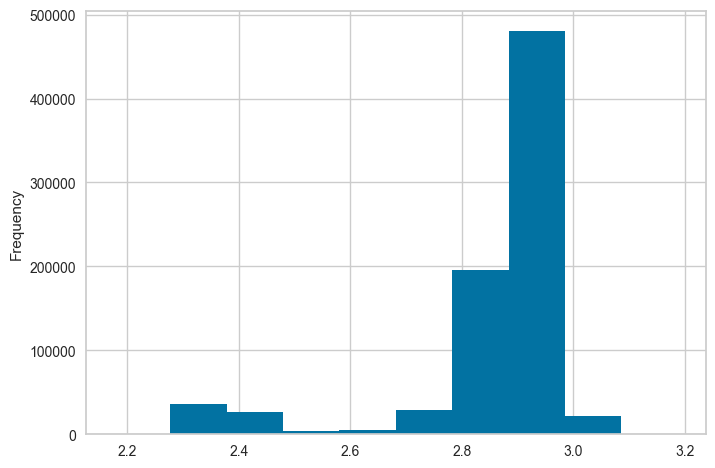

In [40]:
pd.Series(binned_model.predict(X_val_preprocessed)).plot.hist()

<Axes: ylabel='Frequency'>

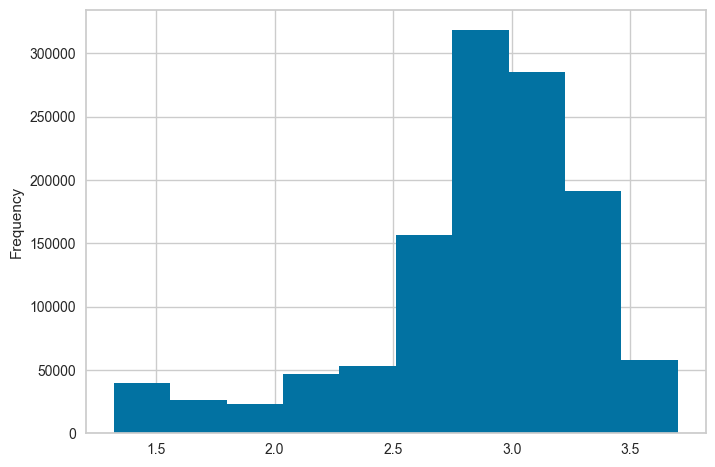

In [41]:
y_train.plot.hist()

In [1]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    xgb_model = xgb.XGBRegressor(enable_categorical=True, eta=0.05, colsample_bytree=0.75, num_boost_round=500)
    model = Pipeline([
        ("preproc", preprocessor),
        ("xgb", xgb_model),
        #("xgb", BinnedXGBRegressionModel(
        #n_bins=2
        #,regressor_base_model=xgb.XGBRegressor(enable_categorical=True, eta=0.5, colsample_bytree=0.75, num_boost_round=500)
        #,classifier_base_model=xgb.XGBClassifier(enable_categorical=True, eta=0.5, colsample_bytree=0.75, num_boost_round=500))
        #)
    ])
    model.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(model.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(model.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

NameError: name 'X_train' is not defined

In [198]:
importances = pd.Series(model.get_booster().get_score(importance_type='total_gain')).reset_index()
importances.columns = ["column", "gain"]
importances["rand_var"] = importances["column"].str.contains("rand_var")

importances["better_than_probe_avg"] = (importances["gain"] > importances.loc[importances["rand_var"], "gain"].mean()) & ~importances["rand_var"]
importances =importances.sort_values(by="gain")
usable_columns = list(importances[importances["better_than_probe_avg"]]["column"].values)

# LightGBM Limited Features

In [213]:
X_train_fixed = X_train.loc[:, usable_columns]

In [231]:
usable_columns

['Customer Tenure',
 'Marital Status_null',
 'Policy Start Year',
 'Customer Feedback_null',
 'Health Score',
 'Previous Claims',
 'Credit Score',
 'Annual Income']

In [218]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(enable_categorical=True, eta=0.1
                             , colsample_bytree=1.0, num_boost_round=5000)
    model.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(model.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(model.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0414319480241936, False), Test: ('rmsle', 1.0443248048531553, False)
Starting
Train: ('rmsle', 1.0409693537040736, False), Test: ('rmsle', 1.0461658721352969, False)
Starting
Train: ('rmsle', 1.04124619189709, False), Test: ('rmsle', 1.0447801409767128, False)
Starting
Train: ('rmsle', 1.0410541920096403, False), Test: ('rmsle', 1.0460724699143016, False)
Starting
Train: ('rmsle', 1.0416228339266616, False), Test: ('rmsle', 1.0436687891507819, False)


In [219]:
importances = pd.Series(model.get_booster().get_score(importance_type='total_gain')).reset_index()
importances.columns = ["column", "gain"]
importances["rand_var"] = importances["column"].str.contains("rand_var")

importances["better_than_probe_avg"] = (importances["gain"] > importances.loc[importances["rand_var"], "gain"].mean()) & ~importances["rand_var"]
importances =importances.sort_values(by="gain")
usable_columns = list(importances[importances["better_than_probe_avg"]]["column"].values)

In [220]:
importances

,column,gain,rand_var,better_than_probe_avg
15,Smoking Status,13.097382,False,False
1,Gender,15.256684,False,False
17,Property Type,38.792526,False,False
9,Policy Type,60.558346,False,False
14,Customer Feedback,72.182533,False,False
3,Marital Status,82.241837,False,False
6,Occupation,84.737862,False,False
5,Education Level,88.832588,False,False
25,Occupation_null,91.203659,False,False
8,Location,95.033760,False,False


In [221]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

def rescale(series, from_min, from_max, to_min, to_max):
    return to_min + ((series - from_min) * (to_max - to_min)) / (from_max - from_min)

In [223]:
model = model.fit(X_train, y_train)

In [225]:
model.save_model("results_201224_1828_limited_columns.pkl")

In [226]:
y_train_pred = model.predict(X_train)#.loc[:, usable_columns])
y_val_pred = model.predict(X_val)#.loc[:, usable_columns])


In [227]:
res_Data = full_test_csv_data[["id"]].copy()

In [228]:
res_Data["pred"] = np.power(10, y_val_pred) - 1

In [229]:
res_Data.columns = ["id","Premium Amount"]

In [230]:
res_Data.to_csv("results_201224_1828_limited_columns.csv",index=False,header=True)